In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.lines import Line2D
import os
from pathlib import Path

# Memory spaces
- Global vs local memory
- Different strides between elements
- Read in global memory and write in:
    - Global mem
    - Local mem
- No computation

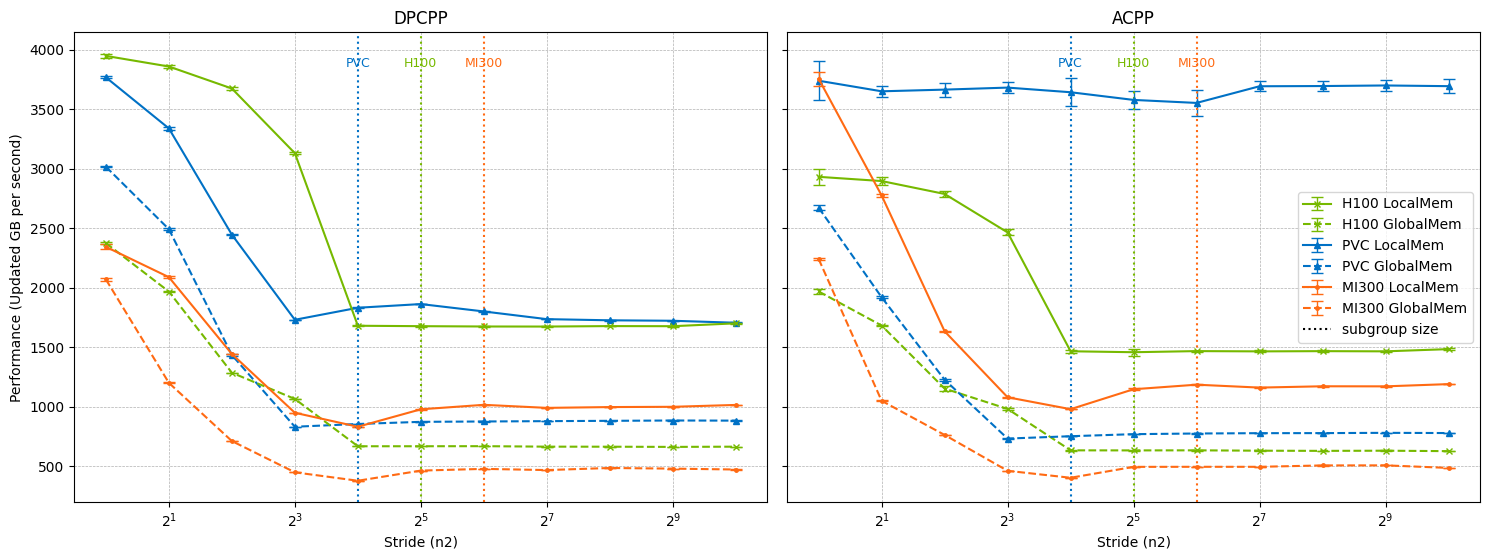

In [2]:


# Configuration
folder = "memory-spaces/"
compilers = ["dpcpp", "acpp"]
hardware_colors = {
    "h100": "#76B900",  # NVIDIA green
    "pvc": "#0071C5",   # Intel blue
    "mi300": "#FF6A13",
}

subgroup_sizes = {
    "h100": 32,   # NVIDIA warp
    "pvc": 16,    # Intel subgroup
    "mi300": 64
}

hardware_markers = {
    "h100": 'x',  # small cross
    "pvc": '^',   # triangle up
    # Add more markers here as needed
}

# Set up subplots: one per compiler
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for ax, compiler in zip(axes, compilers):
    file_pattern = f"{folder}/{compiler}_50_reps_*.json"
    json_files = glob.glob(file_pattern)

    all_strides = set()  # Collect all strides for proper x-axis ticks

    for filepath in json_files:
        hardware = os.path.splitext(os.path.basename(filepath))[0].split("_")[-1].lower()
        color = hardware_colors.get(hardware, 'gray')

        with open(filepath) as f:
            data = json.load(f)

        df = pd.DataFrame(data["benchmarks"])
        all_strides.update(df["n2"].unique())  # Collect strides

        means = df[df["aggregate_name"] == "mean"].copy()
        stddevs = df[df["aggregate_name"] == "stddev"].copy()

        merge_keys = ["run_name", "per_family_instance_index"]
        merged = pd.merge(
            means,
            stddevs[merge_keys + ["bytes_per_second"]],
            on=merge_keys,
            suffixes=("", "_stddev")
        )

        merged["mem_type"] = merged["name"].apply(lambda x: "LocalMem" if "LocalMem" in x else "GlobalMem")
        merged["stride"] = merged["n2"]
        merged["GBps"] = merged["bytes_per_second"] / 1e9
        merged["GBps_stddev"] = merged["bytes_per_second_stddev"] / 1e9

        for mem_type, style in [("LocalMem", "-"), ("GlobalMem", "--")]:
            subset = merged[merged["mem_type"] == mem_type].sort_values("stride")
            label = f"{hardware.upper()} {mem_type}"

            ax.errorbar(
                subset["stride"],
                subset["GBps"],
                yerr=subset["GBps_stddev"],
                capsize=4,
                elinewidth=1,
                label=label,
                linestyle=style,
                marker=hardware_markers.get(hardware, '.'),
                markersize=5,
                color=color
            )

    # Set log2 scale and base-10 stride labels
    all_strides = sorted(all_strides)
    ax.set_xscale("log", base=2)
    # ax.set_xticklabels([str(np.log2(x)) for x in all_strides])
    # ax.set_xticks(all_strides)
    ax.set_xlabel("Stride (n2)")
    ax.set_title(f"{compiler.upper()}")

    # Add subgroup size marker lines
    for hw, size in subgroup_sizes.items():
        if hw in hardware_colors:
            ax.axvline(x=size, color=hardware_colors[hw], linestyle=":", linewidth=1.5)
            ax.text(
                size, ax.get_ylim()[1] * 0.95,
                f"{hw.upper()}",
                color=hardware_colors[hw],
                ha="center", va="top", fontsize=9
            )

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Custom legend line for subgroup size marker
subgroup_legend = Line2D(
    [0], [0],
    color='black',
    linestyle=':',
    linewidth=1.5,
    label='subgroup size'
)
# Single legend on second subplot
axes[1].legend(handles=[*axes[1].get_legend_handles_labels()[0], subgroup_legend], loc="best")
# Shared Y label
axes[0].set_ylabel("Performance (Updated GB per second)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("memory-spaces.pdf")
plt.show()


# Operations order

- Copy/solve vs solve/copy
- 2 applications with 2 sizes each (total elements 2**28):
    - conv1d
        - k=1, l=8192, c=1, n=32768
        - k=3, l=2048, c=4, n=32768
    - lag advection
        - n0=32768, n1=8192, n2=1
        - n0=1024, n1=8192, n2=32


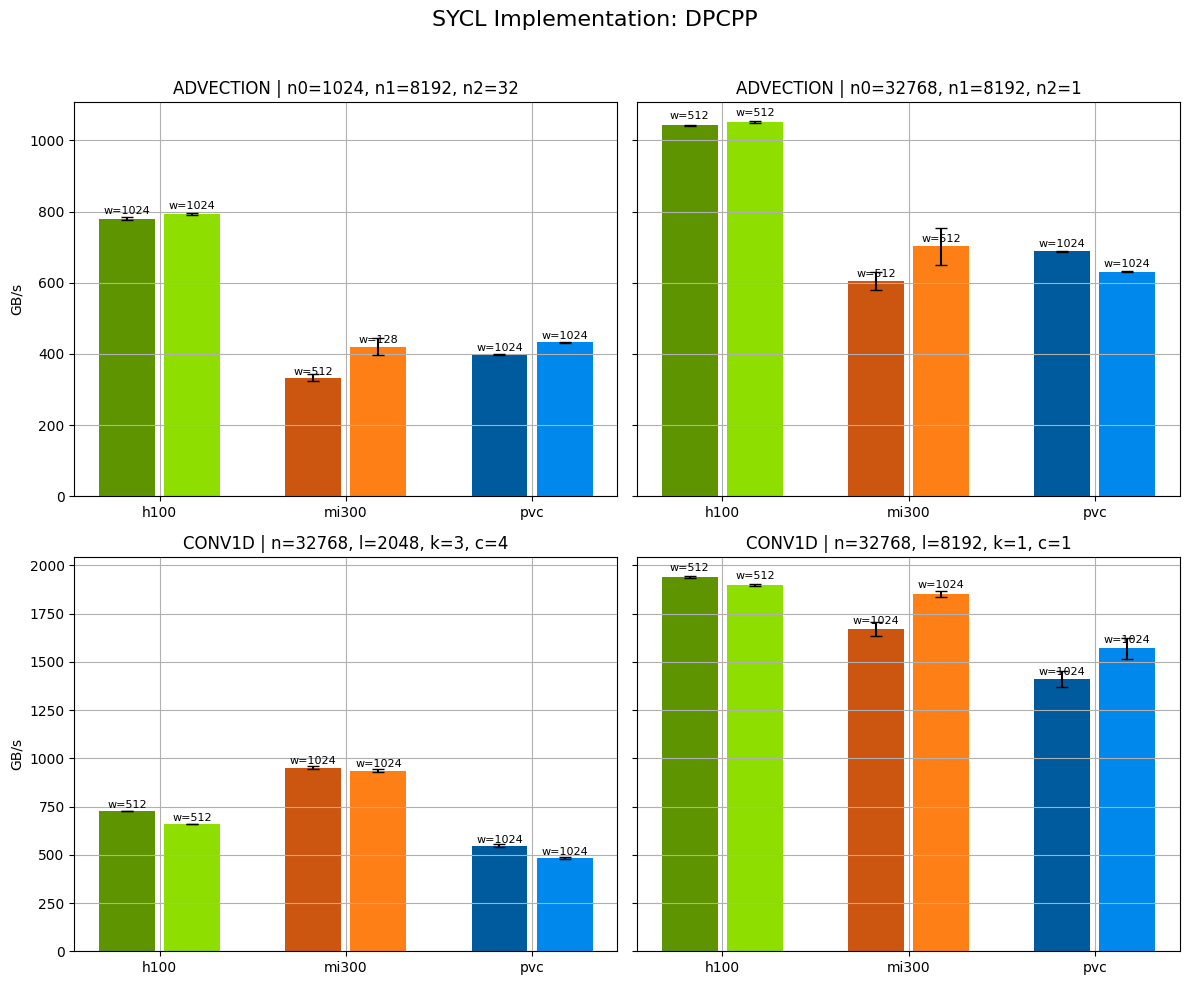

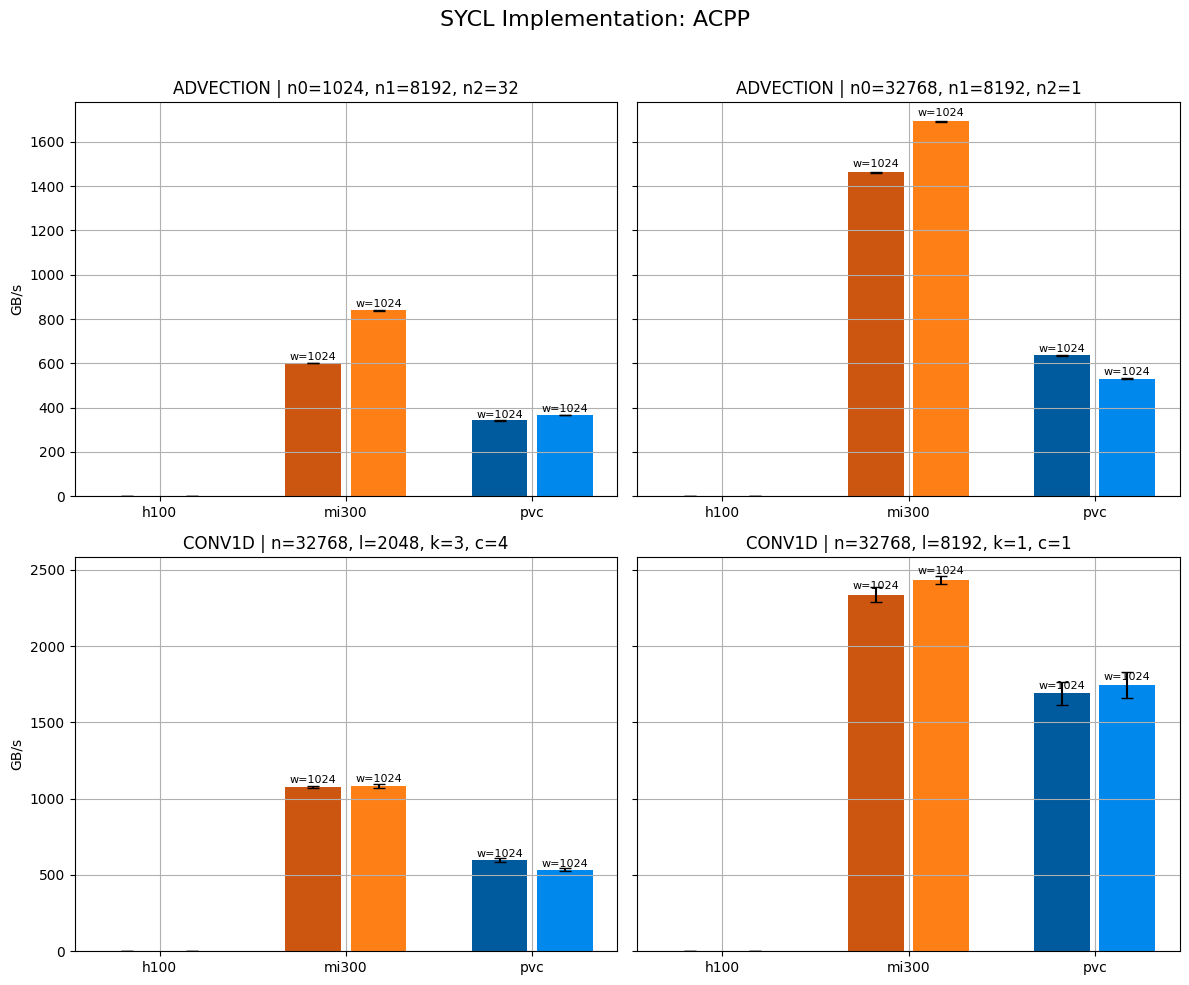

In [18]:
import os
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict

# Constants
base_dir = Path("/home/ac.amillan/source/phd-experiments/out/op-order")
orders = ["copy_solve", "solve_copy"]
hardware_list = ['h100', 'mi300', 'pvc']
hardware_colors = {'h100': '#76B900', 'mi300': '#FF6A13', 'pvc': '#0071C5'}
order_factors = {'copy_solve': 0.8, 'solve_copy': 1.2}

def adjust_color_brightness(hex_color, factor=1.0):
    rgb = mcolors.to_rgb(hex_color)
    adjusted = [min(1, max(0, c * factor)) for c in rgb]
    return mcolors.to_hex(adjusted)

# Load and parse benchmark data
records = []
for order in orders:
    order_path = base_dir / order
    for file in order_path.glob("*.json"):
        parts = file.stem.split("_")
        if len(parts) != 3:
            continue
        app, hw, impl = parts
        if impl not in ['dpcpp', 'acpp'] or hw not in hardware_list:
            continue
        with open(file) as f:
            data = json.load(f)
            benchmarks = data["benchmarks"]
            grouped = defaultdict(dict)
            for b in benchmarks:
                if "aggregate_name" in b:
                    run_id = b.get("run_name", b.get("name"))
                    grouped[run_id][b["aggregate_name"]] = b
            for run, agg in grouped.items():
                if "mean" in agg and "stddev" in agg:
                    b_mean = agg["mean"]
                    b_std = agg["stddev"]
                    if app == "conv1d":
                        n = int(float(b_mean.get("batch_size", 0)))
                        l = int(float(b_mean.get("input_length", 0)))
                        k = int(float(b_mean.get("kernel_size", 0)))
                        c = int(float(b_mean.get("channels", 0)))
                        size_str = f"n={n}, l={l}, k={k}, c={c}"
                    else:
                        n0 = int(float(b_mean.get("n0", 0)))
                        n1 = int(float(b_mean.get("n1", 0)))
                        n2 = int(float(b_mean.get("n2", 0)))
                        size_str = f"n0={n0}, n1={n1}, n2={n2}"
                    records.append({
                        "app": app,
                        "size": size_str,
                        "hardware": hw,
                        "impl": impl,
                        "order": order,
                        "mean_bps": b_mean["bytes_per_second"],
                        "std_bps": b_std["bytes_per_second"],
                        "w": b_mean.get("pref_wg_size", None)
                    })

df = pd.DataFrame(records)
df = df.loc[df.groupby(["app", "size", "hardware", "impl", "order"])["mean_bps"].idxmax()]

if df.empty:
    print("No benchmark data found.")
else:
    for impl in df["impl"].unique():
        impl_df = df[df["impl"] == impl]
        apps = ["advection", "conv1d"]
        app_sizes = {app: sorted(impl_df[impl_df["app"] == app]["size"].unique()) for app in apps}

        # Layout: rows = apps, cols = max number of sizes
        max_cols = max(len(s) for s in app_sizes.values())
        fig, axs = plt.subplots(nrows=2, ncols=max_cols, figsize=(6 * max_cols, 10), sharey='row')
        if max_cols == 1:
            axs = axs.reshape(2, 1)

        for row_idx, app in enumerate(apps):
            sizes = app_sizes[app]
            for col_idx, size in enumerate(sizes):
                ax = axs[row_idx, col_idx]
                size_df = impl_df[(impl_df["app"] == app) & (impl_df["size"] == size)]
                for i, hw in enumerate(hardware_list):
                    for j, order in enumerate(orders):
                        row = size_df.query(f"hardware == '{hw}' and order == '{order}'")
                        if not row.empty:
                            row = row.iloc[0]
                            mean_val = row['mean_bps'] / 1e9
                            std_val = row['std_bps'] / 1e9
                            w_val = row['w']
                        else:
                            mean_val = 0
                            std_val = 0
                            w_val = None
                        color = adjust_color_brightness(hardware_colors[hw], order_factors[order])
                        xpos = i + j * 0.35 - 0.175
                        ax.bar(xpos, mean_val, yerr=std_val, width=0.3, color=color, capsize=4)
                        if w_val is not None:
                            ax.text(xpos, mean_val + mean_val * 0.01, f"w={int(w_val)}",
                                    ha='center', va='bottom', fontsize=8)
                ax.set_title(f"{app.upper()} | {size}")
                ax.set_xticks(range(len(hardware_list)))
                ax.set_xticklabels(hardware_list)
                ax.grid()

            # Hide unused columns if any
            for empty_col in range(len(sizes), max_cols):
                fig.delaxes(axs[row_idx, empty_col])

        axs[0, 0].set_ylabel("GB/s")
        axs[1, 0].set_ylabel("GB/s")
        fig.suptitle(f"SYCL Implementation: {impl.upper()}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f"operations-order-structured-{impl}.pdf")
        plt.show()


# AdaptiveWg experiments

- 2 objectives to show:
    - no overhead compared to NDRange when d1 is contiguous
    - performance gain when d1 is non contiguous
- Only advection
- two sizes
    - n0=32768, n1=8192, n2=1
    - n0=1024, n1=8192, n2=32


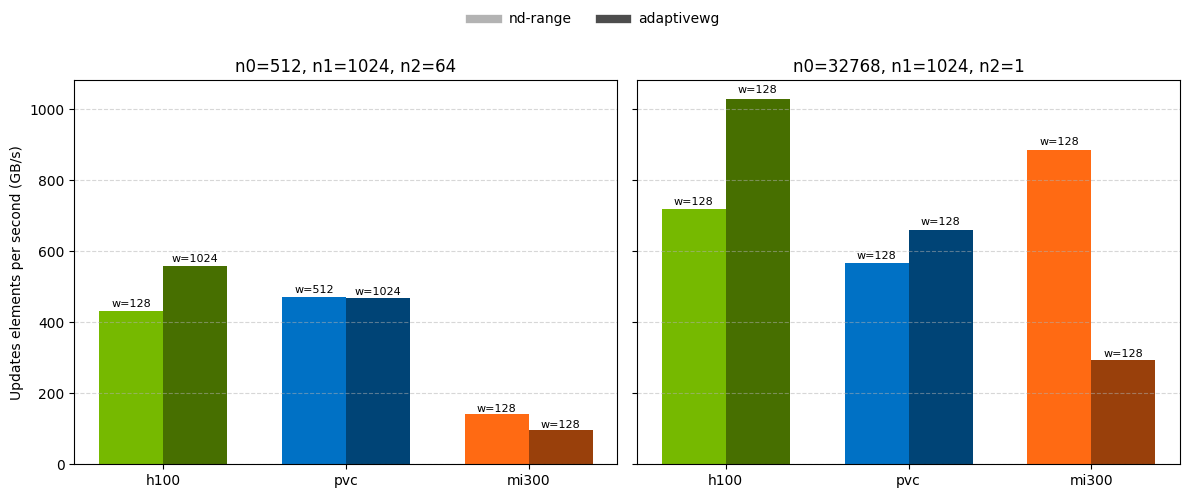

In [36]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# hardware color mapping
hw_colors = {
    'h100': '#76B900',
    'pvc': '#0071C5',
    'mi300': '#FF6A13'
}
shade_factor = 0.6

# load all JSONs in folder
data = []

for filepath in glob.glob('/home/ac.amillan/source/phd-experiments/out/adaptive-wg/advection_*_dpcpp.json'):
    fname = os.path.basename(filepath)
    hw = fname.split('_')[1]
    with open(filepath) as f:
        j = json.load(f)
    temp_data = []
    for b in j['benchmarks']:
        if b['aggregate_name'] == 'mean':
            temp_data.append({
                'hardware': hw,
                'n0': b['n0'],
                'n1': b['n1'],
                'n2': b['n2'],
                'kernel_id': int(b['kernel_id']),
                'bytes_per_second': b['bytes_per_second'],
                'stddev': None,
                'w': b.get('pref_wg_size', None)
            })
        elif b['aggregate_name'] == 'stddev':
            for entry in reversed(temp_data):
                if (entry['hardware'] == hw and
                    entry['n0'] == b['n0'] and
                    entry['n1'] == b['n1'] and
                    entry['n2'] == b['n2'] and
                    entry['kernel_id'] == int(b['kernel_id'])):
                    entry['stddev'] = b['real_time']
                    break
    data.extend(temp_data)

df = pd.DataFrame(data)
df = df.loc[df.groupby(['n0', 'n1', 'n2', 'hardware', 'kernel_id'])['bytes_per_second'].idxmax()]
sizes = df[['n0','n1','n2']].drop_duplicates().sort_values(['n0','n1','n2']).values

fig, axs = plt.subplots(1, len(sizes), figsize=(12, 5), sharey=True)

for ax, (n0, n1, n2) in zip(axs, sizes):
    df_size = df[(df.n0==n0) & (df.n1==n1) & (df.n2==n2)]
    hw_list = sorted(df_size['hardware'].unique(), key=lambda x: list(hw_colors).index(x))
    x = np.arange(len(hw_list))
    width = 0.35

    for i, hw in enumerate(hw_list):
        for k_id, offset in [(0, -width/2), (1, width/2)]:
            row = df_size[(df_size.hardware == hw) & (df_size.kernel_id == k_id)]
            if row.empty:
                continue
            row = row.iloc[0]
            y = row['bytes_per_second'] / 1e9
            yerr = row['stddev']
            w_val = row['w']
            base_color = hw_colors[hw]
            if k_id == 0:
                color = base_color
            else:
                rgb = np.array(mcolors.to_rgb(base_color))
                color = rgb * shade_factor
            ax.bar(x[i] + offset, y, width, color=color, yerr=yerr, capsize=3)
            ax.text(x[i] + offset, y + y * 0.01, f'w={int(w_val)}',
                    ha='center', va='bottom', fontsize=8)

    ax.set_xticks(x)
    ax.set_xticklabels(hw_list)
    ax.set_title(f'n0={int(n0)}, n1={int(n1)}, n2={int(n2)}')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axs[0].set_ylabel('Updates elements per second (GB/s)')

# Grayscale legend for kernel types
custom_lines = [
    plt.Line2D([0], [0], color='0.7', lw=6, label='nd-range'),
    plt.Line2D([0], [0], color='0.3', lw=6, label='adaptivewg')
]
fig.legend(handles=custom_lines, loc='upper center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.92])
fig.savefig("adaptivewg-vs-ndrange.pdf")

# Adaptive wg new
plus de tailles

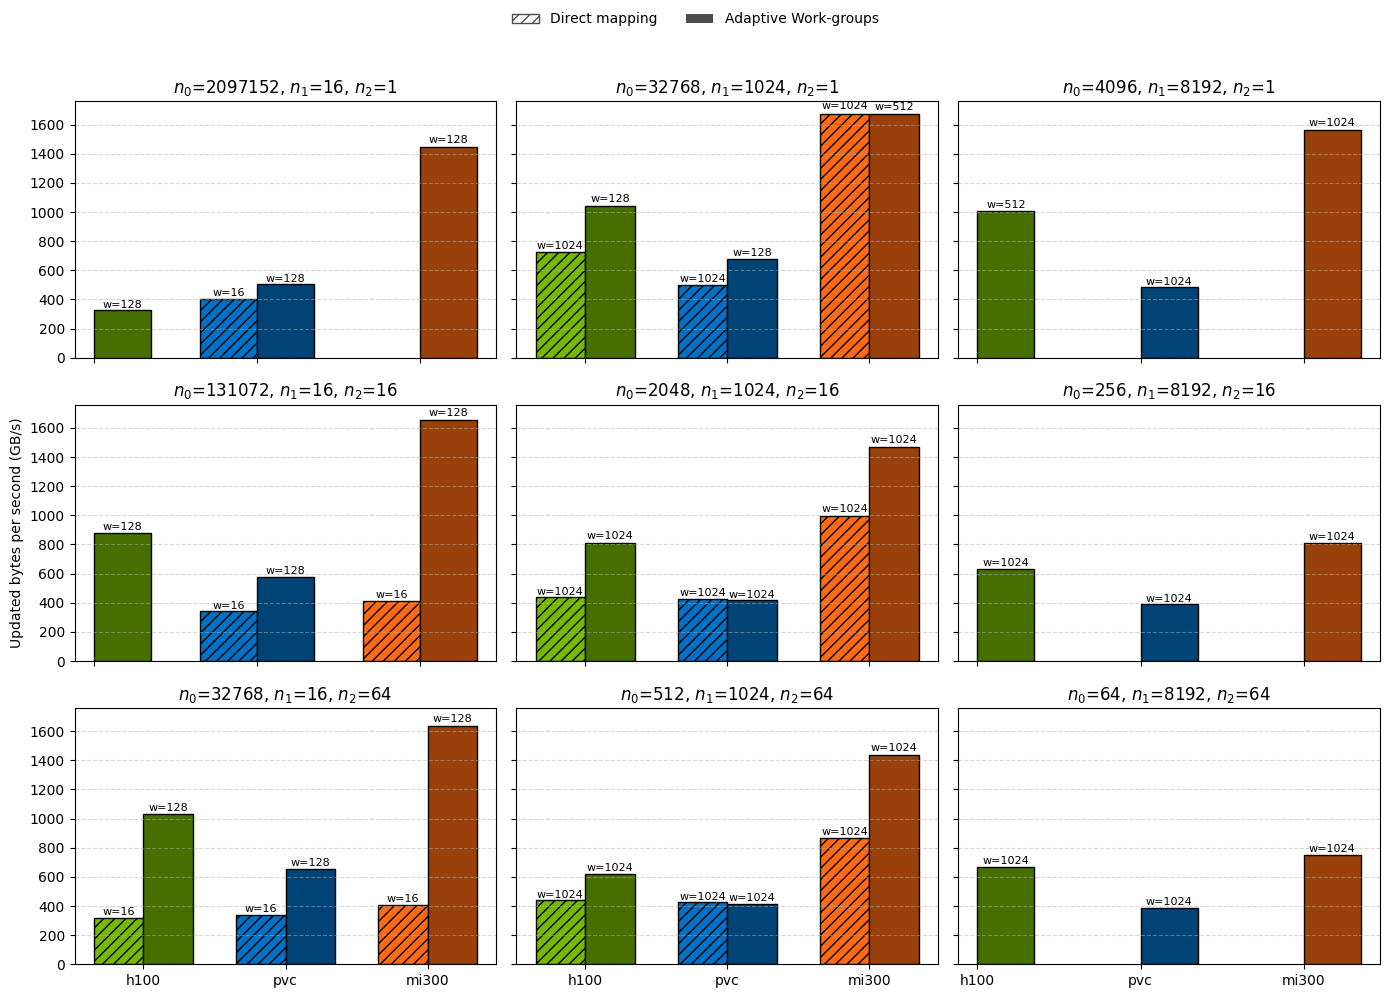

In [3]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import math

# hardware color mapping
hw_colors = {
    'h100': '#76B900',
    'pvc': '#0071C5',
    'mi300': '#FF6A13'
}
shade_factor = 0.6

# load all JSONs in folder
data = []

for filepath in glob.glob('/home/ac.amillan/source/phd-experiments/out/adaptive-wg-new/advection_*.json'):
    fname = os.path.basename(filepath)
    parts = fname.split('_')
    hw = parts[1]  # e.g., h100

    with open(filepath) as f:
        j = json.load(f)
    temp_data = []
    for b in j['benchmarks']:
        if 'aggregate_name' not in b:
            continue

        kernel_id = b['kernel_id']

        if b['aggregate_name'] == 'mean':
            temp_data.append({
                'hardware': hw,
                'n0': b['n0'],
                'n1': b['n1'],
                'n2': b['n2'],
                'kernel_id': kernel_id,
                'bytes_per_second': b['bytes_per_second'],
                'stddev': None,
                'w': b.get('pref_wg_size', None)
            })
        elif b['aggregate_name'] == 'stddev':
            for entry in reversed(temp_data):
                if (entry['hardware'] == hw and
                    entry['n0'] == b['n0'] and
                    entry['n1'] == b['n1'] and
                    entry['n2'] == b['n2'] and
                    entry['kernel_id'] == kernel_id):
                    entry['stddev'] = b['real_time']
                    break
    data.extend(temp_data)

# df = pd.DataFrame(data)
# df = df.loc[df.groupby(['n0', 'n1', 'n2', 'hardware', 'kernel_id'])['bytes_per_second'].idxmax()]

# df = pd.DataFrame(data)
# # Séparer les deux types de kernel
# df_adaptive = df[df.kernel_id == 1]
# df_ndrange = df[(df.kernel_id == 0) & (df.w == df.n1)]
# # Pour adaptive, on garde la meilleure perf par config
# df_adaptive = df_adaptive.loc[df_adaptive.groupby(['n0', 'n1', 'n2', 'hardware'])['bytes_per_second'].idxmax()]
# # Pour ndrange, on garde uniquement w == n1, peu importe la perf
# # et on déduplique si besoin (on prend le premier si plusieurs)
# df_ndrange = df_ndrange.drop_duplicates(subset=['n0', 'n1', 'n2', 'hardware'])
# # Fusionner
# df = pd.concat([df_ndrange, df_adaptive])

df = pd.DataFrame(data)

# Séparer les deux types de kernel
df_adaptive = df[df.kernel_id == 1]
df_ndrange_all = df[df.kernel_id == 0]

# Pour adaptive, on garde la meilleure perf par config
df_adaptive = df_adaptive.loc[df_adaptive.groupby(['n0', 'n1', 'n2', 'hardware'])['bytes_per_second'].idxmax()]

# Pour ndrange : priorité à w == n1, sinon meilleure perf et on force w = n1
ndrange_rows = []
for (n0, n1, n2, hw), group in df_ndrange_all.groupby(['n0', 'n1', 'n2', 'hardware']):
    match = group[group.w == n1]
    if not match.empty:
        ndrange_rows.append(match.iloc[0])
    else:
        best = group.loc[group['bytes_per_second'].idxmax()].copy()
        best['w'] = n1  # override for display consistency
        ndrange_rows.append(best)

df_ndrange = pd.DataFrame(ndrange_rows)

# Fusionner
df = pd.concat([df_ndrange, df_adaptive])

# define custom plot layout
ordering = [
    (2**21, 16, 1), (2**15, 1024, 1), (2**12, 8192, 1),
    (2**17, 16, 16), (2**11, 1024, 16), (2**8, 8192, 16),
    (2**15, 16, 64), (2**9, 1024, 64), (2**6, 8192, 64)
]

fig, axs = plt.subplots(3, 3, figsize=(14, 10), sharey=True)
axs = axs.flatten()

for ax_idx, (ax, (n0, n1, n2)) in enumerate(zip(axs, ordering)):
    df_size = df[(df.n0==n0) & (df.n1==n1) & (df.n2==n2)]
    if df_size.empty:
        ax.axis('off')
        continue
    hw_list = sorted(df_size['hardware'].unique(), key=lambda x: list(hw_colors).index(x))
    x = np.arange(len(hw_list))
    width = 0.35

    for i, hw in enumerate(hw_list):
        for k_id, offset in [(0, -width/2), (1, width/2)]:
            row = df_size[(df_size.hardware == hw) & (df_size.kernel_id == k_id)]
            if row.empty:
                continue
            row = row.iloc[0]
            y = row['bytes_per_second'] / 1e9
            yerr = row['stddev']
            w_val = row['w']
            base_color = hw_colors[hw]
            color = base_color if k_id == 0 else np.array(mcolors.to_rgb(base_color)) * shade_factor
            hatch = '///' if k_id == 0 else None
            ax.bar(x[i] + offset, y, width, color=color, yerr=yerr, capsize=3, hatch=hatch, edgecolor='black')
            ax.text(x[i] + offset, y + y * 0.01, f'w={int(w_val)}',
                    ha='center', va='bottom', fontsize=8)

    ax.set_xticks(x)
    ax.set_xticklabels(hw_list)
    ax.set_title(f'$n_0$={int(n0)}, $n_1$={int(n1)}, $n_2$={int(n2)}')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

for ax in axs:
    ax.label_outer()
axs[3].set_ylabel('Updated bytes per second (GB/s)')

# Legend workaround with hatching
from matplotlib.patches import Patch
custom_lines = [
    Patch(facecolor='white', edgecolor='0.3', hatch='///', label='Direct mapping'),
    Patch(facecolor='0.3', label='Adaptive Work-groups')
]
fig.legend(handles=custom_lines, loc='upper center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.94])
fig.savefig("adaptivewg-vs-ndrange-all-sizes.pdf")


# Seq size

Impact of seqsize parameter on the batched dimensions.

### Seq size0

```cpp
static expe size0{32768, 1024, 1};
static bm_vec_t SEQ_SIZE0 = {1, 2, 4, 8, 16, 32, 64, 128, 256, 512};
static bm_vec_t SEQ_SIZE2 = {1};
```

### Seq size2

```cpp
static expe size1{1, 1024, 32768};
static bm_vec_t SEQ_SIZE0 = {1};
static bm_vec_t SEQ_SIZE2 = {1, 2, 4, 8, 16, 32, 64, 128, 256, 512};
```

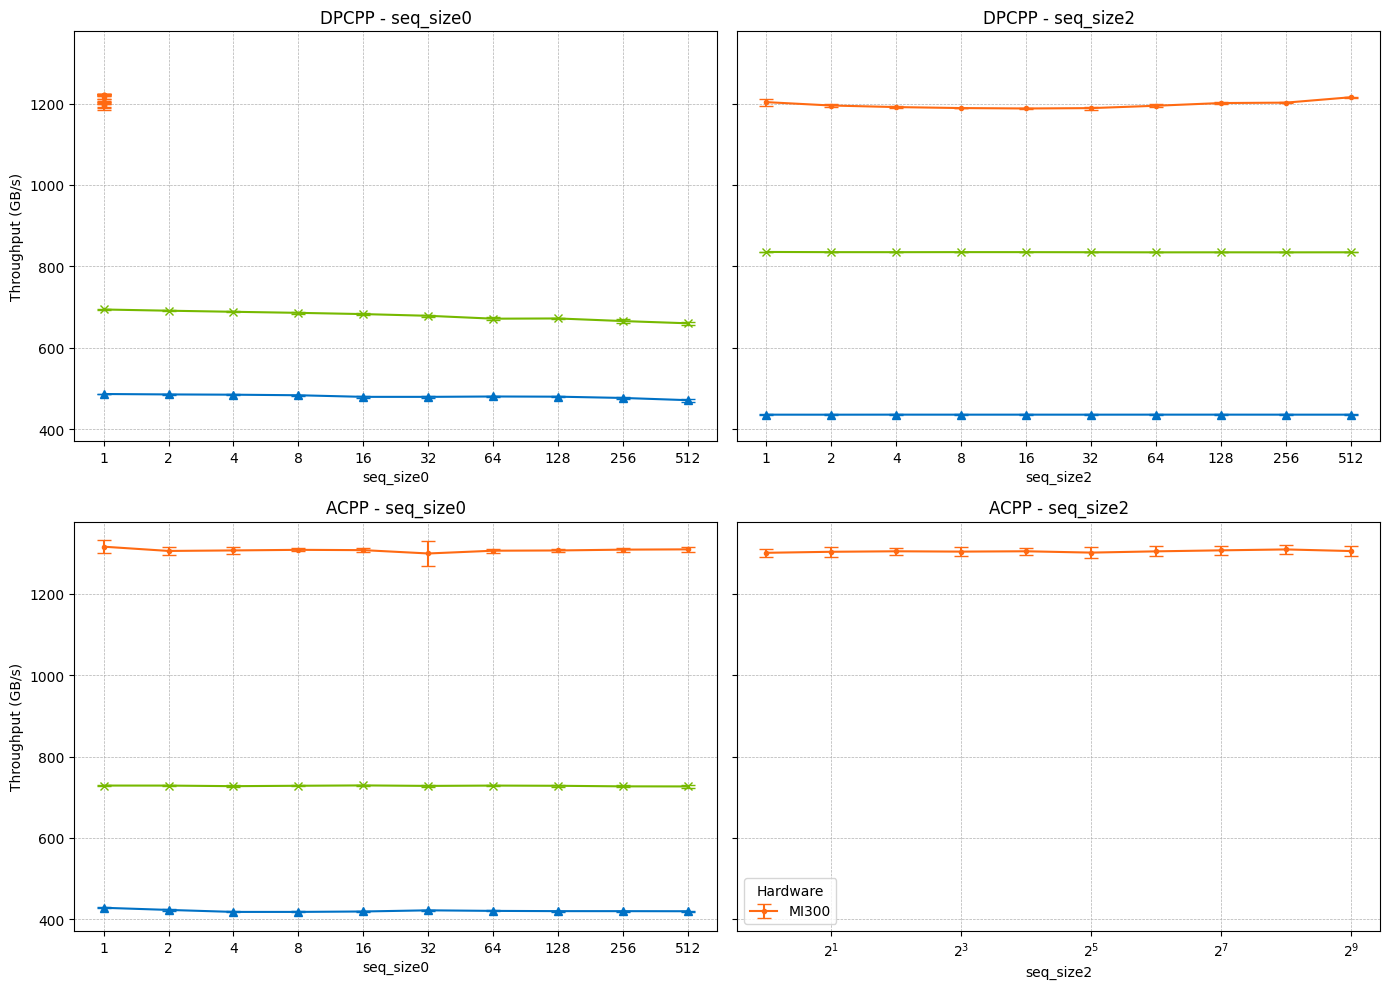

In [3]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Hardware config: color and marker
hardware_styles = {
    "h100": {"color": "#76B900", "marker": "x"},
    "pvc": {"color": "#0071C5", "marker": "^"},
    "mi300": {"color": "#FF6A13", "marker": "."}
}

def load_data(filename, seq_key):
    if not os.path.exists(filename):
        print(f"Warning: File not found: {filename}")
        return [], [], []
    with open(filename) as f:
        data = json.load(f)
    benchmarks = data["benchmarks"]
    means = [b for b in benchmarks if b["aggregate_name"] == "mean"]
    stddevs = {b["per_family_instance_index"]: b["real_time"] for b in benchmarks if b["aggregate_name"] == "stddev"}
    seq_sizes = [b[seq_key] for b in means]
    gbps = [b["bytes_per_second"] / 1e9 for b in means]
    errors = [
        stddevs.get(b["per_family_instance_index"], 0) / b["real_time"] * b["bytes_per_second"] / 1e9
        for b in means
    ]
    return seq_sizes, gbps, errors

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

compilers = ["dpcpp", "acpp"]
seq_keys = ["seq_size0", "seq_size2"]

for row, compiler in enumerate(compilers):
    for col, seq_key in enumerate(seq_keys):
        ax = axs[row, col]
        for hw in ["h100", "mi300", "pvc"]:
            filepath = f"seqsize/advection_{hw}_{compiler}_{seq_key}.json"
            x, y, yerr = load_data(filepath, seq_key)
            if not x:
                continue
            style = hardware_styles[hw]
            ax.errorbar(x, y, yerr=yerr, fmt=style["marker"]+"-", capsize=5,
                        color=style["color"], label=hw.upper())
        ax.set_xscale('log', base=2)
        if x:
            ax.set_xticks(x)
            ax.set_xticklabels([str(int(v)) for v in x])
        ax.set_xlabel(f'{seq_key}')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        if col == 0:
            ax.set_ylabel('Throughput (GB/s)')
        ax.set_title(f'{compiler.upper()} - {seq_key}')
        if row == 1 and col == 1:
            ax.legend(title="Hardware")

plt.tight_layout()
plt.savefig("seqsize_2x2.pdf")
plt.show()


# Outer loop

Checking the scaling of the runtime when submitting sub-batches

```cpp
static expe s0{1, 512, 1};
static expe s1{2, 512, 1};
static expe s2{4, 512, 1};
static expe s3{8, 512, 1};
static expe s4{16, 512, 1};
static expe s5{32, 512, 1};
static expe s6{64, 512, 1};
static expe s7{128, 512, 1};
static expe s8{256, 512, 1};
static expe s9{512, 512, 1};
static expe s10{1024, 512, 1};
static expe s11{2048, 512, 1};
static expe s12{4096, 512, 1};
static expe s13{8192, 512, 1};
static expe s14{16384, 512, 1};
static expe s15{32768, 512, 1};
static expe s16{65536, 512, 1};
static expe s17{131072, 512, 1};
static expe s18{262144, 512, 1};
static expe s19{524288, 512, 1};
static expe s20{1048576, 512, 1};
static expe s21{2097152, 512, 1};
static expe s22{4194304, 512, 1};
static expe s23{8388608, 512, 1};
static expe s24{16777216, 512, 1};
// static expe s25{16777216*2, 512, 1};

static std::vector EXP_SIZES{
    s0, s1, s2, s3, s4, s5, s6, s7, s8, s9,
    s10, s11, s12, s13, s14, s15, s16, s17, s18, s19,
    s20, s21, s22, s23, s24
};
```

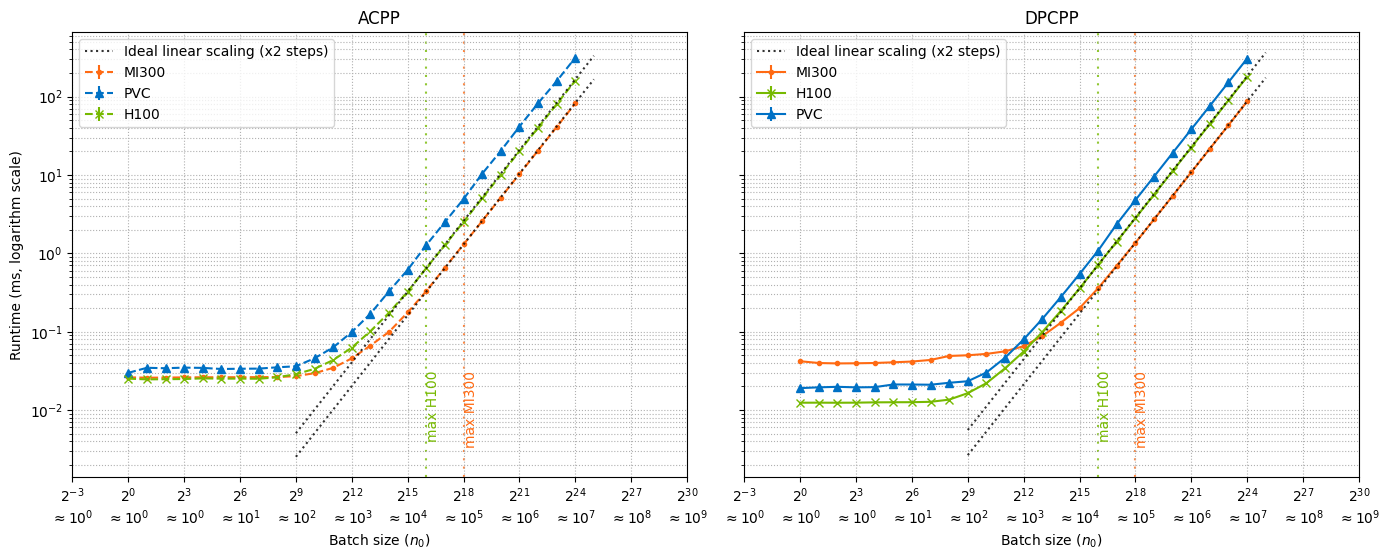

In [35]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import to_rgba

# Constants
hardware_styles = {
    "h100": {"color": "#76B900", "marker": "x"},
    "mi300": {"color": "#FF6A13", "marker": "."},
    "pvc": {"color": "#0071C5", "marker": "^"},
}
impl_styles = {
    "acpp": {"linestyle": "--"},
    "dpcpp": {"linestyle": "-"},
}
limits = {
    "h100": (2**16 - 1, 0.8),
    "mi300": (262144, 0.8),
}

# Organize data by implementation
data_by_impl = {"acpp": [], "dpcpp": []}

for filepath in glob.glob("outer-loop/advection_*.json"):
    filename = os.path.basename(filepath)
    hw, impl = filename.split("_")[1:3]
    impl = impl.split(".")[0]
    data_by_impl[impl].append((hw, filepath))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
impl_names = {"acpp": "ACPP", "dpcpp": "DPCPP"}

for ax, impl in zip(axes, ["acpp", "dpcpp"]):
    plotted_scaling = False
    ax.set_title(f"{impl_names[impl]}")

    for hw, filepath in data_by_impl[impl]:
        with open(filepath) as f:
            data = json.load(f)

        runs = {}
        for bench in data["benchmarks"]:
            if bench["aggregate_name"] == "mean":
                key = int(bench["n0"])
                runs[key] = {"mean": bench["real_time"]}
            elif bench["aggregate_name"] == "stddev":
                key = int(bench["n0"])
                if key in runs:
                    runs[key]["stddev"] = bench["real_time"]

        if not runs:
            continue

        x = sorted(runs.keys())
        y = [runs[k]["mean"] for k in x]
        yerr = [runs[k].get("stddev", 0) for k in x]

        label = f"{hw.upper()}"
        color = hardware_styles[hw]["color"]
        marker = hardware_styles[hw]["marker"]
        linestyle = impl_styles[impl]["linestyle"]

        ax.errorbar(x, y, yerr=yerr, label=label, color=color, linestyle=linestyle, marker=marker, zorder=2)

        if hw in limits:
            hw_limit = limits[hw][0]
            ref_index = next((i for i, xi in enumerate(x) if xi >= hw_limit), 0)
            ref_x = x[ref_index]
            ref_y = y[ref_index]
            x_scale = [2**i for i in range(9, 26)]
            scale_y = [ref_y * (xi / ref_x) for xi in x_scale]
            if not plotted_scaling:
                ax.plot(x_scale, scale_y, linestyle=":", color="black", alpha=0.8, label="Ideal linear scaling (x2 steps)", zorder=3)
                plotted_scaling = True
            else:
                ax.plot(x_scale, scale_y, linestyle=":", color="black", alpha=0.8, zorder=3)

    for hw, (limit_x, alpha) in limits.items():
        color = hardware_styles[hw]["color"]
        rgba = to_rgba(color, alpha)
        ax.axvline(limit_x, color=rgba, linestyle=(0, (1, 3)), linewidth=1.5, zorder=1)
        ax.text(limit_x+2, 10**-1.5, f"max {hw.upper()}", rotation=90, color=color, alpha=1, va="top")

    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.set_xlim(left=1)
    ax.set_xlabel("Batch size ($n_0$)")
    ax.grid(True, which="both", ls=":")

axes[0].set_ylabel("Runtime (ms, logarithm scale)")

# Custom x-ticks with powers of two and approximate decimal equivalents
xticks = axes[0].get_xticks()
xticklabels = [f"$2^{{{int(np.log2(x))}}}$\n$\\approx 10^{{{int(np.log10(x))}}}$" if x > 0 else "" for x in xticks]
for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

# Deduplicated legends
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys())

# fig.suptitle("Runtime vs $n_0$ batch size with fixed $n_1 = 512$, $n_2=1$", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("outer-loop-runtime-scaling.pdf")
plt.show()


# Gysela experiments

`smiluations/geometryXYVxVy/landeau/landeau_fft`

configurations:
```py
    {"x": 128, "y": 128, "vx": 64, "vy": 64},
    {"x": 1024, "y": 1024, "vx": 32, "vy": 32},
    {"x": 512, "y": 512, "vx": 64, "vy": 64},
```

# Parallel advection 2D experiments

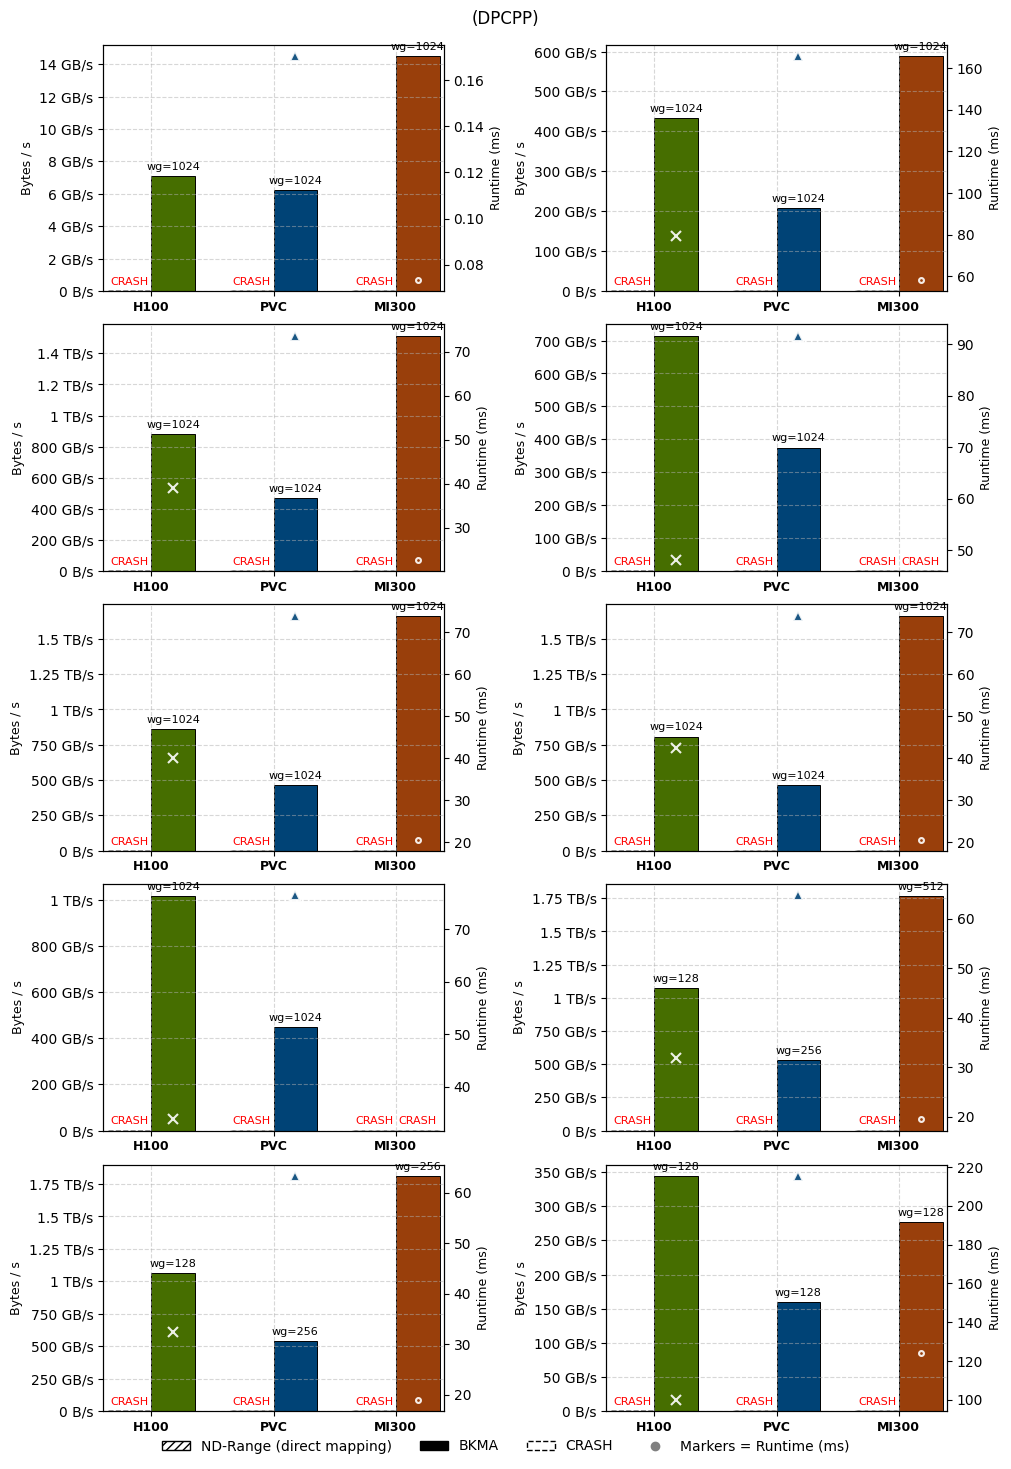

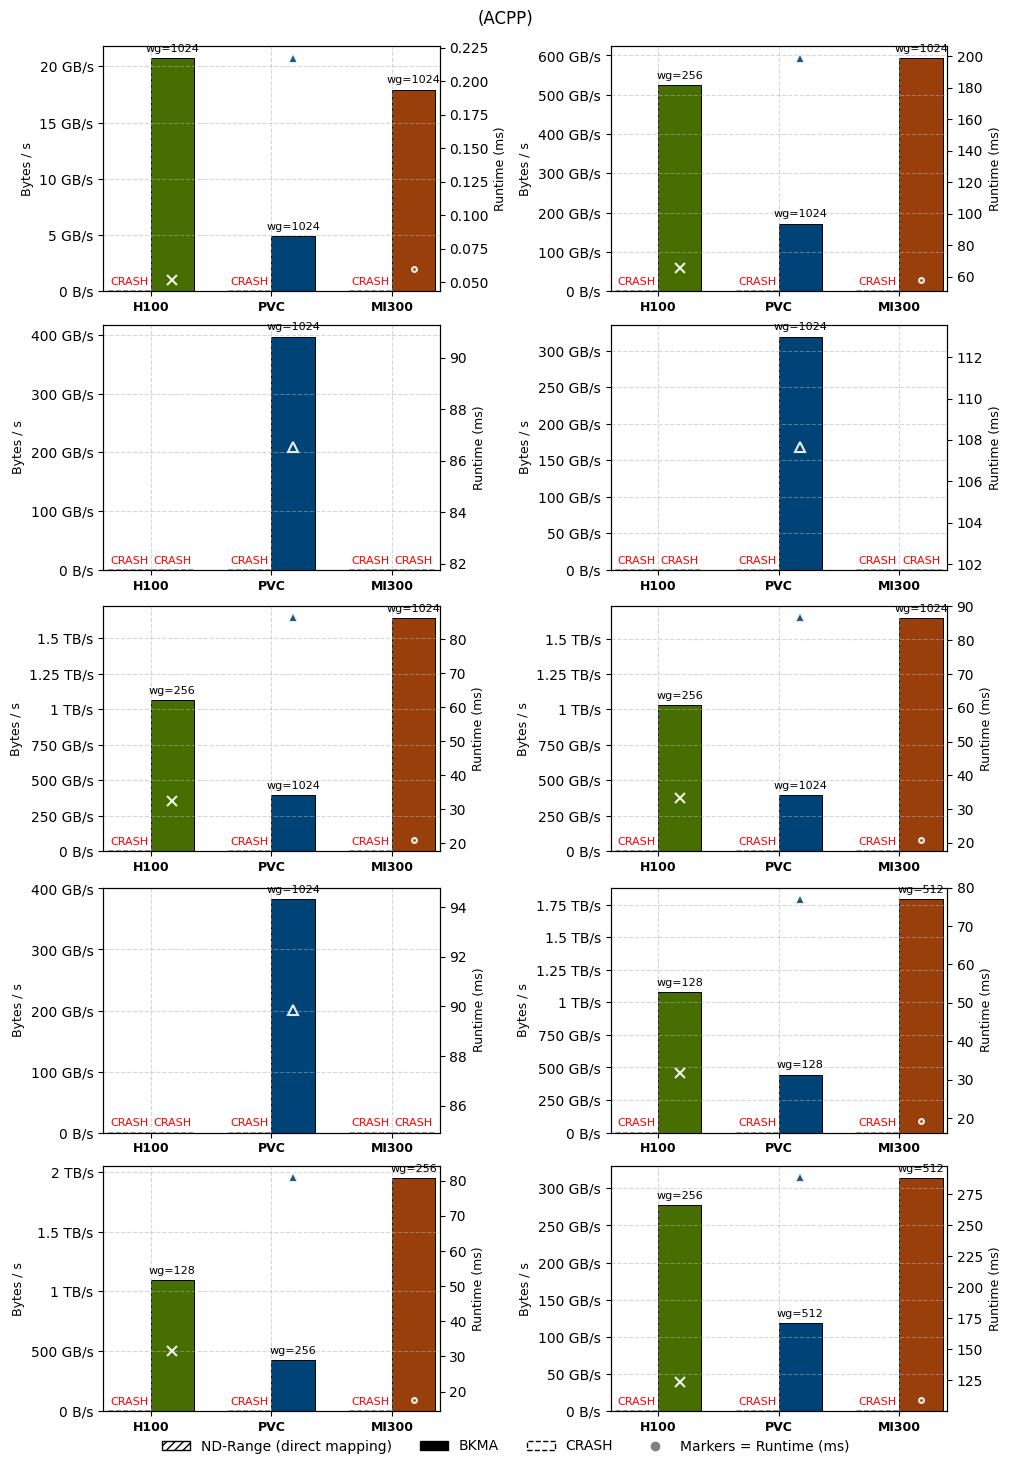

In [ ]:
import json, glob, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

DATA_DIR = Path("parallel-adv")

# ---- Appearance ----
HW_STYLE = {
    "h100":  {"color": "#76B900", "marker": "x", "order": 0},
    "pvc":   {"color": "#0071C5", "marker": "^", "order": 1},
    "mi300": {"color": "#FF6A13", "marker": ".", "order": 2},
}

def darken_color(hex_color, factor=0.6):
    rgb = np.array([int(hex_color[i:i+2], 16) for i in (1, 3, 5)]) / 255
    rgb_dark = np.clip(rgb * factor, 0, 1)
    return "#" + "".join(f"{int(c*255):02X}" for c in rgb_dark)

HW_STYLE_DARK = {
    hw: {"color": darken_color(style["color"]), "marker": style["marker"], "order": style["order"]}
    for hw, style in HW_STYLE.items()
}

IMPL_HATCH = {
    "bkma": "",
    "ndrange": "////"
}

IMPL_LABELS = {
    "bkma": "BKMA",
    "ndrange": "ND-Range (direct mapping)"
}

# ---- Hardware peak throughput (Bytes/s) ----
HW_PEAK = {
    "h100": 4.0e12,
    "pvc":  3.5e12,
    "mi300": 5.0e12
}

BAR_W = 1.0
GROUP_GAP = 0.8
RUNTIME_LABEL = "Runtime (ms)"
THRPT_LABEL  = "Bytes / s"
FIGSIZE = (10, 14)  # 5 x 2 layout

# ---- Helpers ----
def parse_meta_from_filename(p: Path):
    m = re.search(r"(h100|pvc|mi300)", p.stem, re.IGNORECASE)
    if not m:
        raise ValueError(f"Cannot parse hardware from {p.name}")
    hw = m.group(1).lower()
    return hw

def load_one_json(p: Path, impl_suffix: str) -> pd.DataFrame:
    with open(p, "r") as f:
        raw = json.load(f)
    df = pd.json_normalize(raw["benchmarks"])
    df = df[(df["run_type"] == "aggregate")]
    df = df[df["aggregate_name"].isin(["mean", "stddev"])]
    df = df[df["run_name"].str.contains(r"/real_time$", regex=True)]
    hw = parse_meta_from_filename(p)
    impl = "ndrange" if "ndrange" in str(p.parent) else "bkma"
    df["hardware"] = hw
    df["impl"] = impl
    for col in ["n0", "n1", "n2", "pref_wg_size"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df["size_tuple"] = list(zip(df["n0"].round().astype("Int64"),
                                df["n1"].round().astype("Int64"),
                                df["n2"].round().astype("Int64")))
    df["size_label"] = df["size_tuple"].apply(
        lambda t: f"{t[0]}×{t[1]}×{t[2]}" if pd.notna(t[0]) else "unknown")
    return df

def pick_best_wg(df: pd.DataFrame) -> pd.DataFrame:
    means = df[df["aggregate_name"] == "mean"].copy()
    stds  = df[df["aggregate_name"] == "stddev"].copy()
    key_cols = ["hardware", "impl", "size_label", "pref_wg_size"]
    sel_cols = key_cols + ["real_time", "bytes_per_second"]
    means = means[sel_cols].rename(columns={"real_time":"rt_mean", "bytes_per_second":"bps_mean"})
    stds  = stds[sel_cols].rename(columns={"real_time":"rt_std",  "bytes_per_second":"bps_std"})
    merged = pd.merge(means, stds, on=key_cols, how="left")
    idx = merged.groupby(["hardware","impl","size_label"])["rt_mean"].idxmin()
    best = merged.loc[idx].copy()
    best["wg"] = best["pref_wg_size"].round().astype(int)
    best["hw_order"] = best["hardware"].map({k:v["order"] for k,v in HW_STYLE.items()})
    best = best.sort_values(["size_label","hw_order","impl"])
    return best

def plot_impl_pair(impl_suffix: str):
    # Load both normal and ND-range JSONs for this impl
    files = sorted(glob.glob(str(DATA_DIR / f"*_{impl_suffix}.json"))) + \
            sorted(glob.glob(str(DATA_DIR / "ndrange" / f"*_{impl_suffix}.json")))
    dfs = []
    for fp in files:
        try:
            dfs.append(load_one_json(Path(fp), impl_suffix))
        except Exception as e:
            print(f"Skip {fp}: {e}")
    if not dfs:
        raise RuntimeError(f"No valid files parsed for {impl_suffix}.")
    all_df = pd.concat(dfs, ignore_index=True)
    best = pick_best_wg(all_df)

    unique_sizes = sorted(best["size_label"].unique(),
                          key=lambda s: tuple(int(x) for x in re.split(r"[×x]", s)))
    sizes_for_grid = unique_sizes[:10]

    nrows, ncols = 5, 2
    fig, axes = plt.subplots(nrows, ncols, figsize=FIGSIZE, constrained_layout=True)
    axes = axes.ravel()

    eng_fmt = EngFormatter(unit="B/s")
    HW_ORDER   = ["h100", "pvc", "mi300"]
    IMPL_ORDER = ["ndrange", "bkma"]
    all_combos = pd.MultiIndex.from_product([HW_ORDER, IMPL_ORDER], names=["hardware", "impl"])

    for ax, size_lbl in zip(axes, sizes_for_grid):
        sub = best[best["size_label"] == size_lbl].set_index(["hardware", "impl"])
        sub = sub.reindex(all_combos)
        positions, colors, hatches, markers = [], [], [], []
        for gi, hw in enumerate(HW_ORDER):
            base = gi * (len(IMPL_ORDER) + GROUP_GAP)
            for impl in IMPL_ORDER:
                positions.append(base + IMPL_ORDER.index(impl))
                if impl == "bkma":
                    colors.append(HW_STYLE_DARK[hw]["color"])
                else:
                    colors.append(HW_STYLE[hw]["color"])
                hatches.append(IMPL_HATCH[impl])
                markers.append(HW_STYLE[hw]["marker"])
        x = np.array(positions)
        y_bps = sub["bps_mean"].to_numpy()
        e_bps = sub["bps_std"].to_numpy()
        y_rt  = sub["rt_mean"].to_numpy()
        e_rt  = sub["rt_std"].to_numpy()
        wg_vals = sub["wg"] if "wg" in sub else pd.Series([np.nan]*len(x), index=sub.index)
        # CRASH check
        for i, (bps, (hw, impl)) in enumerate(zip(y_bps, sub.index)):
            if pd.isna(bps) or (hw in HW_PEAK and bps > HW_PEAK[hw]):
                y_bps[i] = np.nan
        # Bars
        for xi, bps, eb, c, h in zip(x, y_bps, e_bps, colors, hatches):
            if pd.isna(bps):
                ax.bar([xi], [0], BAR_W, color="none", edgecolor="black", linewidth=1, linestyle="--")
            else:
                bar = ax.bar([xi], [bps], BAR_W, color=c, edgecolor="black", linewidth=0.7,
                             yerr=None if pd.isna(eb) else [[eb],[eb]],
                             capsize=3, error_kw=dict(alpha=0.7))[0]
                bar.set_hatch(h)
        # WG annotations
        for xi, bps, (hw, impl) in zip(x, y_bps, sub.index):
            if pd.isna(bps):
                ax.annotate("CRASH", xy=(xi, 0), xytext=(0, 3), textcoords="offset points",
                            ha="center", va="bottom", fontsize=8, color="red")
            elif impl != "ndrange" and not pd.isna(wg_vals.loc[(hw, impl)]):
                ax.annotate(f"wg={int(wg_vals.loc[(hw, impl)])}", xy=(xi, bps), xytext=(0, 3),
                            textcoords="offset points", ha="center", va="bottom", fontsize=8)
        # Runtime markers (skip if CRASH)
        ax2 = ax.twinx()
        for xi, bps, rt, er, c, m in zip(x, y_bps, y_rt, e_rt, colors, markers):
            if pd.isna(bps) or pd.isna(rt):
                continue
            ax2.errorbar([xi], [rt], yerr=None if pd.isna(er) else [[er],[er]],
                         fmt=m, color=c, markeredgewidth=1.5, markeredgecolor="white",
                         markersize=7, capsize=3, elinewidth=1, alpha=0.9, zorder=5)
        # X labels
        group_centers = []
        for gi, hw in enumerate(HW_ORDER):
            base = gi * (len(IMPL_ORDER) + GROUP_GAP)
            center = base + (len(IMPL_ORDER) - 1) / 2
            group_centers.append(center)
        ax.set_xticks(group_centers)
        ax.set_xticklabels(["H100", "PVC", "MI300"], fontsize=9, fontweight="bold")
        ax.set_ylabel(THRPT_LABEL, fontsize=9)
        ax2.set_ylabel(RUNTIME_LABEL, fontsize=9)
        ax.yaxis.set_major_formatter(eng_fmt)
        ax.set_xlim(min(x) - 0.6, max(x) + 0.6)
        ax.grid(True, linestyle="--", alpha=0.5)

    # Hide unused axes
    for j in range(len(sizes_for_grid), len(axes)):
        axes[j].axis("off")

    # Legend below plot
    impl_patches = [Patch(facecolor="white" if IMPL_HATCH[k] else "black", edgecolor="black",
                          hatch=IMPL_HATCH[k], label=IMPL_LABELS[k]) for k in IMPL_ORDER]
    crash_proxy = Patch(facecolor="none", edgecolor="black", linestyle="--", label="CRASH")
    runtime_proxy = Line2D([0],[0], marker='o', color='gray', linestyle='None', label="Markers = Runtime (ms)")
    handles = impl_patches + [crash_proxy, runtime_proxy]

    fig.legend(handles=handles, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle(f"({impl_suffix.upper()})", fontsize=12, y=1.02)
    plt.savefig(f"parallel-adv-bench-{impl_suffix}.pdf")
    plt.show()

# ---- Generate both figures ----
for impl in ["dpcpp", "acpp"]:
    plot_impl_pair(impl)


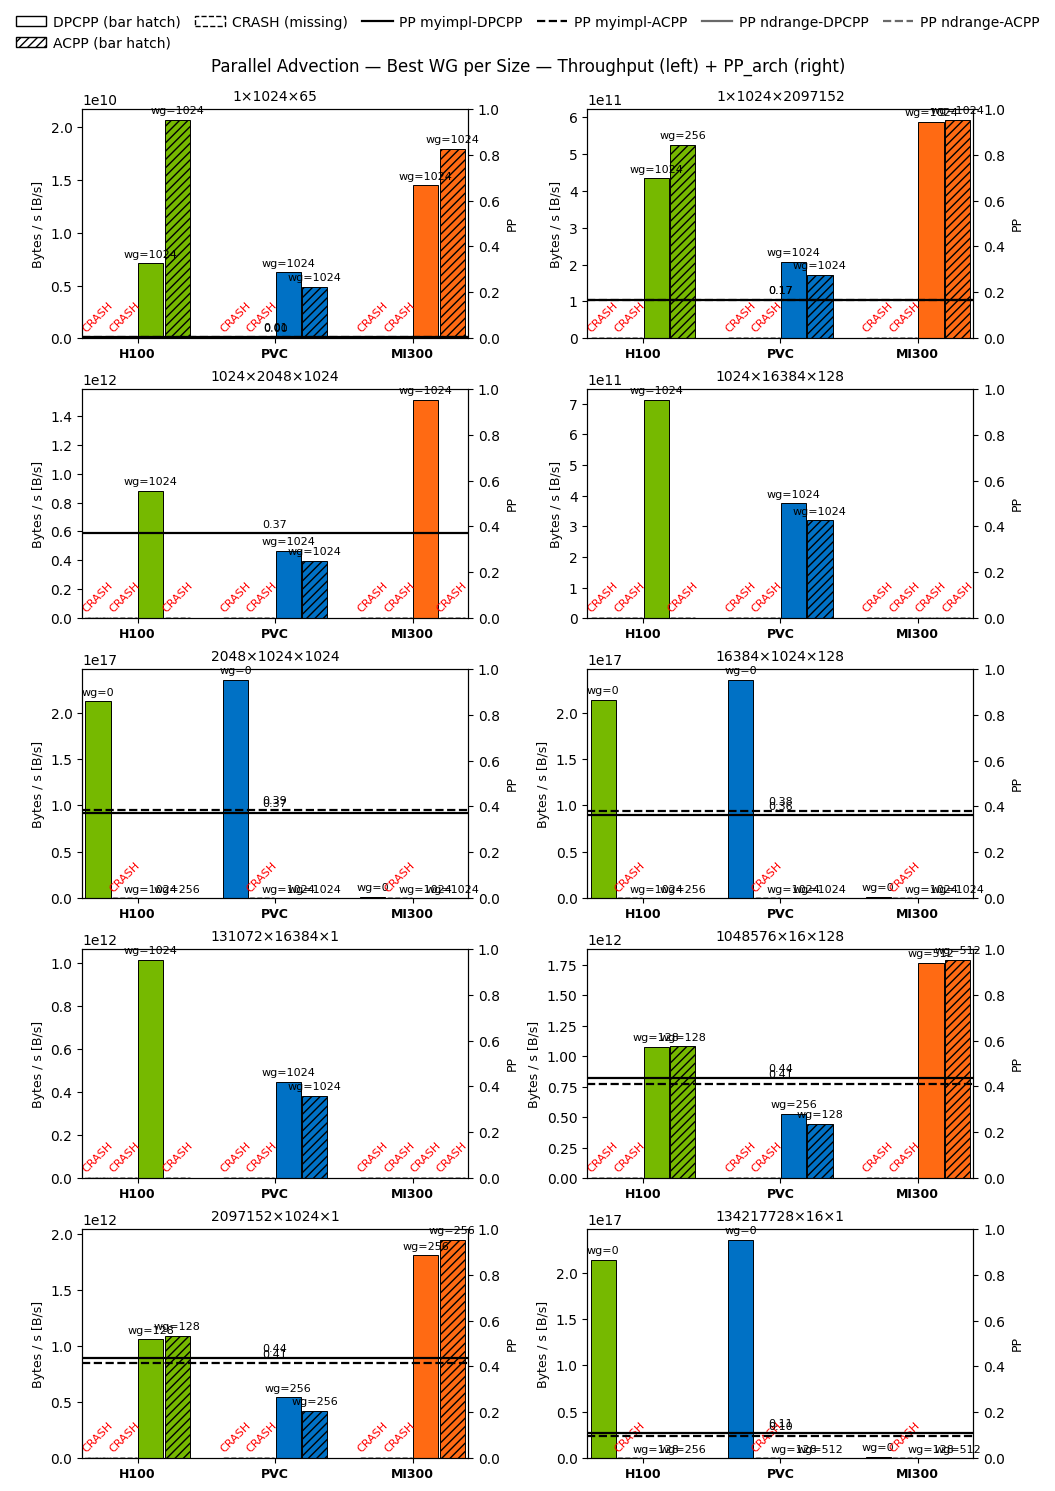

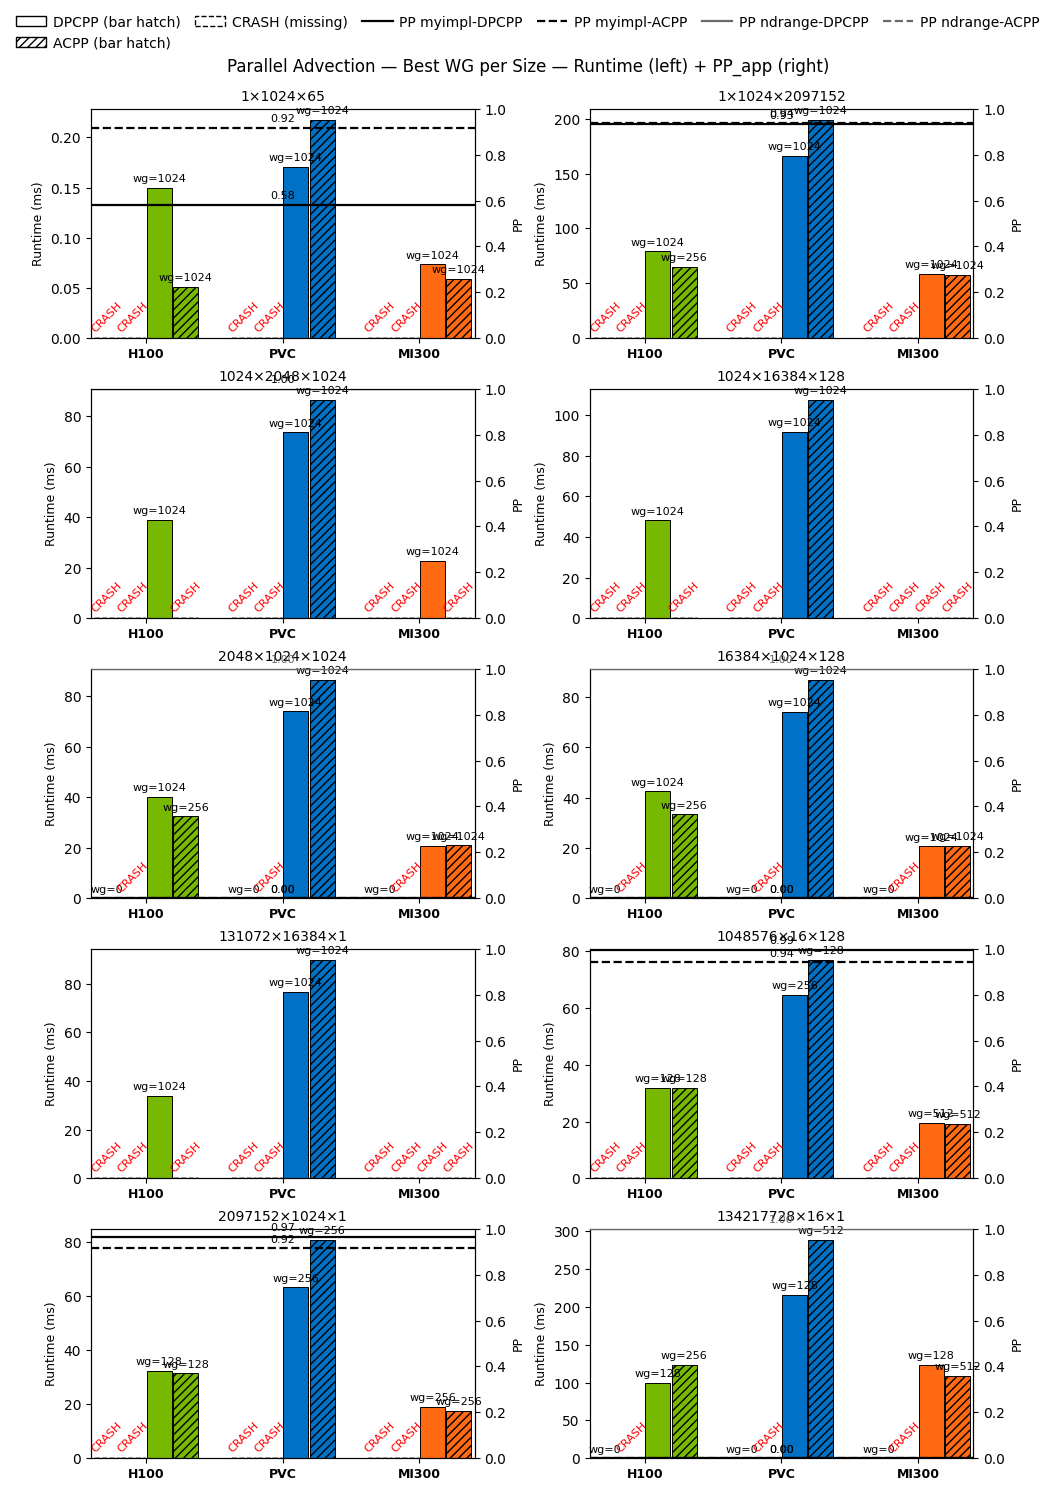

In [47]:
# Jupyter cell

import json, glob, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR_MAIN = Path("parallel-adv")
DATA_DIR_NDR  = DATA_DIR_MAIN / "ndrange"

# ---- Appearance ----
HW_STYLE = {
    "h100":  {"color": "#76B900", "order": 0},
    "pvc":   {"color": "#0071C5", "order": 1},
    "mi300": {"color": "#FF6A13", "order": 2},
}
IMPL_ORDER   = ["dpcpp", "acpp"]
VAR_ORDER    = ["ndrange", "myimpl"]  # plotting order inside each HW group
VAR_COLOR_PP = {"myimpl": "black", "ndrange": "dimgray"}  # PP lines color
IMPL_LS_PP   = {"dpcpp": "-", "acpp": "--"}               # PP lines style

RUNTIME_LABEL = "Runtime (ms)"
THRPT_LABEL  = "Bytes / s"
TITLE = "Parallel Advection — Best WG per Size"
FIGSIZE_2x5 = (10, 14)  # 5 rows x 2 cols

# Hardware peak bandwidths in BYTES/second (strictly required for PP_arch)
ARCH_PEAK_BPS = {
    "h100":  3.35e12,     # ~3.35 TB/s
    "pvc":   1.20e12,     # ~1.2 TB/s
    "mi300": 5.30e12 / 2, # ~5.3 TB/s total, halved for single GCD
}

# ---- Helpers ----
def parse_meta_from_filename(p: Path):
    m = re.search(r"(h100|pvc|mi300).*(dpcpp|acpp)", p.stem, re.IGNORECASE)
    if not m:
        raise ValueError(f"Cannot parse hardware/impl from {p.name}")
    return m.group(1).lower(), m.group(2).lower()

def load_one_json(p: Path, variant: str) -> pd.DataFrame:
    with open(p, "r") as f:
        raw = json.load(f)
    df = pd.json_normalize(raw["benchmarks"])
    df = df[(df["run_type"] == "aggregate")]
    df = df[df["aggregate_name"].isin(["mean", "stddev"])]
    df = df[df["run_name"].str.contains(r"/real_time$", regex=True)]
    hw, impl = parse_meta_from_filename(p)
    df["hardware"] = hw
    df["impl"] = impl
    df["variant"] = variant  # <--- "myimpl" or "ndrange"
    for col in ["n0", "n1", "n2", "pref_wg_size"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df["size_tuple"] = list(zip(df["n0"].round().astype("Int64"),
                                df["n1"].round().astype("Int64"),
                                df["n2"].round().astype("Int64")))
    df["size_label"] = df["size_tuple"].apply(lambda t: f"{t[0]}×{t[1]}×{t[2]}" if pd.notna(t[0]) else "unknown")
    return df

def pick_best_wg(df: pd.DataFrame) -> pd.DataFrame:
    """
    Best WG per (hardware, variant, impl, size).
    """
    means = df[df["aggregate_name"] == "mean"].copy()
    stds  = df[df["aggregate_name"] == "stddev"].copy()
    key_cols = ["hardware", "variant", "impl", "size_label", "pref_wg_size"]
    sel_cols = key_cols + ["real_time", "bytes_per_second"]
    means = means[sel_cols].rename(columns={"real_time":"rt_mean", "bytes_per_second":"bps_mean"})
    stds  = stds[sel_cols].rename(columns={"real_time":"rt_std",  "bytes_per_second":"bps_std"})
    merged = pd.merge(means, stds, on=key_cols, how="left")

    # Best by runtime mean
    idx = merged.groupby(["hardware","variant","impl","size_label"])["rt_mean"].idxmin()
    best = merged.loc[idx].copy()

    best["wg"] = best["pref_wg_size"].round().astype(int)
    best["hw_order"] = best["hardware"].map({k:v["order"] for k,v in HW_STYLE.items()})
    best = best.sort_values(["size_label","hw_order","variant","impl"])
    return best

# ---- Pennycook PP (harmonic mean) ----
def _harmonic_mean(effs):
    effs = [float(e) for e in effs]
    if not effs or any((not np.isfinite(e)) or e <= 0 for e in effs):
        return 0.0
    return len(effs) / sum(1.0/e for e in effs)

def compute_pp_app_runtime(sub_idxed: pd.DataFrame, variant: str, impl: str,
                           hw_order=("h100","pvc","mi300")) -> float:
    """
    PP_app for a given (variant, impl):
      e_app(hw) = min_runtime(hw) / runtime_impl(hw)
    where min_runtime(hw) is the best across *all* variants and impls on that hardware.
    Strict: if any required HW missing/invalid -> 0.
    """
    effs = []
    for hw in hw_order:
        # best runtime on this HW across all variants+impls
        try:
            hw_rt = sub_idxed.loc[(hw, slice(None), slice(None)), "rt_mean"]
        except KeyError:
            return 0.0
        hw_rt = hw_rt.dropna()
        if hw_rt.empty:
            return 0.0
        min_rt = float(hw_rt.min())

        # this (variant, impl) runtime on this HW
        key = (hw, variant, impl)
        if key not in sub_idxed.index:
            return 0.0
        rt_impl = sub_idxed.loc[key, "rt_mean"]
        if not (pd.notna(rt_impl) and np.isfinite(rt_impl) and rt_impl > 0):
            return 0.0

        effs.append(min_rt / float(rt_impl))
    return _harmonic_mean(effs)

def compute_pp_arch_bps(sub_idxed: pd.DataFrame, variant: str, impl: str,
                        hw_order=("h100","pvc","mi300"),
                        arch_peak_bps: dict | None = None) -> float:
    """
    PP_arch for a given (variant, impl):
      e_arch(hw) = bps_impl(hw) / peak_bps(hw)
    Strict: requires peak for each HW and valid data; else 0.
    """
    if arch_peak_bps is None:
        arch_peak_bps = {}
    effs = []
    for hw in hw_order:
        peak = arch_peak_bps.get(hw, None)
        if peak is None or not np.isfinite(peak) or peak <= 0:
            return 0.0
        key = (hw, variant, impl)
        if key not in sub_idxed.index:
            return 0.0
        bps_impl = sub_idxed.loc[key, "bps_mean"]
        if not (pd.notna(bps_impl) and np.isfinite(bps_impl) and bps_impl > 0):
            return 0.0
        effs.append(float(bps_impl) / float(peak))
    return _harmonic_mean(effs)

# ---- Load & prep ----
files_main = sorted(glob.glob(str(DATA_DIR_MAIN / "*.json")))
files_ndr  = sorted(glob.glob(str(DATA_DIR_NDR / "*.json")))

if not files_main and not files_ndr:
    raise FileNotFoundError(f"No JSON files found in {DATA_DIR_MAIN} or {DATA_DIR_NDR}")

dfs = []
for fp in files_main:
    try:
        dfs.append(load_one_json(Path(fp), variant="myimpl"))
    except Exception as e:
        print(f"Skip {fp}: {e}")
for fp in files_ndr:
    try:
        dfs.append(load_one_json(Path(fp), variant="ndrange"))
    except Exception as e:
        print(f"Skip {fp}: {e}")

if not dfs:
    raise RuntimeError("No valid files parsed.")
all_df = pd.concat(dfs, ignore_index=True)

best = pick_best_wg(all_df)

# pick first 10 sizes in natural order
unique_sizes = sorted(best["size_label"].unique(), key=lambda s: tuple(int(x) for x in re.split(r"[×x]", s)))
sizes_for_grid = unique_sizes[:10]

# constants for grouped bars
HW_ORDER = ["h100", "pvc", "mi300"]
# full index: (hardware, variant, impl)
all_combos = pd.MultiIndex.from_product([HW_ORDER, VAR_ORDER, IMPL_ORDER],
                                        names=["hardware", "variant", "impl"])

# positioning: 4 bars per hardware in the requested order
# [ndrange-dpcpp, ndrange-acpp, myimpl-dpcpp, myimpl-acpp]
BAR_W     = 0.95    # impl bars touch within each mini-pair
GROUP_GAP = 1.2     # spacing between hardware groups

# prebuild positions within a hardware group
within_hw_positions = []
within_hw_hatches   = []
for var in VAR_ORDER:          # ndrange, myimpl
    for impl in IMPL_ORDER:    # dpcpp, acpp
        within_hw_positions.append((var, impl))
        within_hw_hatches.append(IMPL_LS_PP[impl])  # reuse mapping later if needed

# Precompute absolute x positions for the 12 slots (3 HW * 4 bars)
positions = []
labels_for_debug = []
for gi, hw in enumerate(HW_ORDER):
    base = gi * (len(within_hw_positions) + GROUP_GAP)
    for ii, (var, impl) in enumerate(within_hw_positions):
        positions.append(base + ii)
        labels_for_debug.append((hw, var, impl))
x = np.array(positions)

# group centers (for "H100 PVC MI300" labels)
group_centers = []
for gi, hw in enumerate(HW_ORDER):
    base = gi * (len(within_hw_positions) + GROUP_GAP)
    center = base + (len(within_hw_positions) - 1) / 2
    group_centers.append(center)
group_labels  = ["H100", "PVC", "MI300"]

def draw_panel(ax, size_lbl, metric: str):
    # sub-data indexed as (hardware, variant, impl)
    sub = best[best["size_label"] == size_lbl].set_index(["hardware","variant","impl"]).reindex(all_combos)

    # extract arrays in plotting order
    colors = [HW_STYLE[hw]["color"] for (hw, _, _) in labels_for_debug]
    hatches = ["" if impl == "dpcpp" else "////" for (_, _, impl) in labels_for_debug]

    # arrays
    y_bps = sub["bps_mean"].reindex(all_combos).to_numpy()
    e_bps = sub["bps_std"].reindex(all_combos).to_numpy()
    y_rt  = sub["rt_mean"].reindex(all_combos).to_numpy()
    e_rt  = sub["rt_std"].reindex(all_combos).to_numpy()

    # draw bars on left axis
    if metric == "bps":
        vals, errs, ylabel = y_bps, e_bps, f"{THRPT_LABEL} [B/s]"
    else:
        vals, errs, ylabel = y_rt, e_rt, RUNTIME_LABEL

    for xi, v, ev, c, h in zip(x, vals, errs, colors, hatches):
        if pd.isna(v):
            ax.bar([xi], [0], BAR_W, color="none", edgecolor="black", linewidth=1, linestyle="--")
        else:
            b = ax.bar([xi], [v], BAR_W, color=c, edgecolor="black", linewidth=0.7,
                       yerr=None if (pd.isna(ev) or (isinstance(ev, float) and np.isnan(ev))) else [[ev],[ev]],
                       capsize=3, error_kw=dict(alpha=0.7))[0]
            b.set_hatch(h)

    # annotate WG or CRASH above the corresponding bar
    wg_vals = sub["wg"] if "wg" in sub else pd.Series([np.nan]*len(all_combos), index=all_combos)
    for xi, key in zip(x, all_combos):
        v = sub.loc[key, "bps_mean"] if metric == "bps" else sub.loc[key, "rt_mean"]
        if pd.isna(v):
            ax.annotate("CRASH", xy=(xi, 0), xytext=(0, 3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=8, color="red", rotation=45)

        else:
            wg = wg_vals.loc[key]
            if pd.notna(wg):
                ax.annotate(f"wg={int(wg)}", xy=(xi, v), xytext=(0, 3), textcoords="offset points",
                            ha="center", va="bottom", fontsize=8)

    # right axis: PP lines in [0,1] for each (variant,impl)
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1.0)
    xmin, xmax = x.min() - 0.6, x.max() + 0.6
    cx = (xmin + xmax) / 2

    pp_pairs = []
    for var in VAR_ORDER:
        for impl in IMPL_ORDER:
            if metric == "bps":
                pp_val = compute_pp_arch_bps(sub, var, impl, HW_ORDER, ARCH_PEAK_BPS)
                label = f"PP_arch {var}-{impl}".upper()
            else:
                pp_val = compute_pp_app_runtime(sub, var, impl, HW_ORDER)
                label = f"PP_app {var}-{impl}".upper()
            pp_pairs.append((var, impl, pp_val, label))

    # draw PP lines: color by variant, linestyle by impl
    for (var, impl, pv, _label) in pp_pairs:
        if not (np.isfinite(pv) and pv > 0):
            continue
        ax2.hlines(y=pv, xmin=xmin, xmax=xmax,
                   colors=VAR_COLOR_PP[var], linestyles=IMPL_LS_PP[impl],
                   linewidth=1.6, zorder=6)
        ax2.annotate(f"{pv:.2f}", xy=(cx, pv), xytext=(0, 3), textcoords="offset points",
                     ha="center", va="bottom", fontsize=8, color=VAR_COLOR_PP[var])

    # cosmetics
    ax.set_title(size_lbl, fontsize=10)
    ax.set_xticks(group_centers)
    ax.set_xticklabels(group_labels, fontsize=9, fontweight="bold")
    ax.set_xlim(xmin, xmax)
    ax.set_ylabel(ylabel, fontsize=9)
    ax2.set_ylabel("PP", fontsize=9)

# ---------- Figure 1: Bytes/s ----------
fig1, axes1 = plt.subplots(5, 2, figsize=FIGSIZE_2x5, constrained_layout=True)
axes1 = axes1.ravel()
for ax, size_lbl in zip(axes1, sizes_for_grid):
    draw_panel(ax, size_lbl, metric="bps")
for j in range(len(sizes_for_grid), len(axes1)):
    axes1[j].axis("off")

# ---------- Figure 2: Runtime ----------
fig2, axes2 = plt.subplots(5, 2, figsize=FIGSIZE_2x5, constrained_layout=True)
axes2 = axes2.ravel()
for ax, size_lbl in zip(axes2, sizes_for_grid):
    draw_panel(ax, size_lbl, metric="rt")
for j in range(len(sizes_for_grid), len(axes2)):
    axes2[j].axis("off")

# Legends (shared): bars -> impl hatch; PP lines -> variant color + impl linestyle; CRASH placeholder
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

impl_patches = [
    Patch(facecolor="white", edgecolor="black", hatch="",      label="DPCPP (bar hatch)"),
    Patch(facecolor="white", edgecolor="black", hatch="////",  label="ACPP (bar hatch)"),
]
crash_proxy  = Patch(facecolor="none", edgecolor="black", linestyle="--", label="CRASH (missing)")
pp_my_d = Line2D([0],[0], color=VAR_COLOR_PP["myimpl"], linestyle=IMPL_LS_PP["dpcpp"], linewidth=1.6, label="PP myimpl-DPCPP")
pp_my_a = Line2D([0],[0], color=VAR_COLOR_PP["myimpl"], linestyle=IMPL_LS_PP["acpp"],  linewidth=1.6, label="PP myimpl-ACPP")
pp_nd_d = Line2D([0],[0], color=VAR_COLOR_PP["ndrange"], linestyle=IMPL_LS_PP["dpcpp"], linewidth=1.6, label="PP ndrange-DPCPP")
pp_nd_a = Line2D([0],[0], color=VAR_COLOR_PP["ndrange"], linestyle=IMPL_LS_PP["acpp"],  linewidth=1.6, label="PP ndrange-ACPP")

handles = impl_patches + [crash_proxy, pp_my_d, pp_my_a, pp_nd_d, pp_nd_a]

for fig in (fig1, fig2):
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.06),
               ncol=6, frameon=False, handlelength=2.2, columnspacing=1.0, handletextpad=0.5, borderaxespad=0.6)

fig1.suptitle(f"{TITLE} — Throughput (left) + PP_arch (right)", fontsize=12, y=1.02)
fig2.suptitle(f"{TITLE} — Runtime (left) + PP_app (right)", fontsize=12, y=1.02)

plt.show()
